In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from G_model import model_single_timestep

pd.options.mode.chained_assignment = None  # Suppress the warning

In [2]:
# Load parameters from YAML file
with open('config/parameters.yml', 'r') as file:
    param = yaml.safe_load(file)

In [3]:
# Load data
df = pd.read_csv('data/generated data/df_500.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['qs'].fillna(method='ffill', inplace=True)
df['qs'][0] = df['qs'][1]
df['batch_id'] = df['batch_id'].astype(str).str.zfill(3)
# check of all NaN are removed
df.isna().sum()

time        0
biomass     0
glucose     0
batch_id    0
qs          0
dtype: int64

In [4]:
# Normalization
df_norm = df.drop(['time', 'batch_id'], axis=1).copy()
mean = df_norm.mean()
std = df_norm.std()
df_norm = (df_norm - mean) / std
df_norm['time'] = df['time']
df_norm['batch_id'] = df['batch_id']

In [5]:
# group the df by batch_id and take the maximum value of qs
## output is an array (shape: [50,2]) which contains all unique batch_ids and a corresponding max qs
# based on the mean value a binary col is created
## when splitting the data in train & test it is ensured that high and low values of qs are equally distributed
df_grouped = df_norm.groupby('batch_id')['qs'].max().reset_index()
mean_qs = df_grouped['qs'].mean()
df_grouped['bin'] = df_grouped['qs'].apply(lambda x: 1 if x > mean_qs else 0)

# Split in the list of unique batch_ids into train and test
## I take the batch_ids instead of the whole dataset because otherwise snippets of one batch can be in
## both train and test set
## result is better because it has already seen the data
b_train, b_test = train_test_split(df_grouped, test_size=0.2, stratify=df_grouped['bin'], random_state=42)

In [6]:
b_train = list(b_train['batch_id'].values)
b_test = list(b_test['batch_id'].values)

df_train = df[df['batch_id'].isin(b_train)]
df_test = df[df['batch_id'].isin(b_test)]

# Define X and y
X_train = df_train.copy().drop(['qs'], axis=1)
y_train = df_train['qs'].values

X_test = df_test.copy().drop(['qs'], axis=1)
y_test = df_test['qs'].values

In [7]:
model = RandomForestRegressor(n_estimators=10, min_samples_leaf=15 ,random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=15, n_estimators=10, random_state=42)

In [8]:
batch_ids = X_test['batch_id'].unique()
one_batch = X_test[X_test['batch_id'] == batch_ids[0]]

df_hybrid = pd.DataFrame()

In [9]:
for b in range(len(batch_ids)):
    one_batch = X_test[X_test['batch_id'] == batch_ids[b]]

    # Simulation settings
    t0 = 0
    t_end = 45.8
    delta_t = 2
    dt = delta_t/60
    num_steps = int((t_end - t0) / dt) + 1 # Number of time steps

    time = np.linspace(t0, t_end, num_steps)
    biomass = np.zeros(num_steps)
    substrate = np.zeros(num_steps)
    volume = np.zeros(num_steps)
    uptake_rate = np.zeros(num_steps)

    # Extract parameters
    X0 = param['X0']
    S0 = param['S0']
    V0 = param['V0']

    # Set initial values
    biomass[0] = X0
    substrate[0] = S0
    volume[0] = V0
    
    for i in range(1, num_steps):
        # calculating qs    
        input = one_batch.iloc[[i]]
        qs = model.predict(input)
        uptake_rate[i] = qs[0]

        # previous values
        c_glucose = substrate[i-1]
        c_biomass = biomass[i-1]
        vol = volume[i-1]

        # new values from model
        biomass[i], substrate[i], volume[i] = model_single_timestep(i, qs[0], c_biomass, c_glucose, vol)
    
    one_batch['biomass_sim'] = biomass
    one_batch['glucose_sim'] = substrate
    one_batch['volume_sim'] = volume

    df_hybrid = pd.concat([df_hybrid, one_batch])

In [20]:
batch_ids_hybrid = df_hybrid['batch_id'].unique()
batch_ids_hybrid[:10]

array(['001', '004', '014', '017', '021', '027', '039', '041', '068',
       '080'], dtype=object)

In [21]:
one_batch_hybrid = df_hybrid[df_hybrid['batch_id'] == '004']
one_batch_plot = X_test[X_test['batch_id'] == '004']

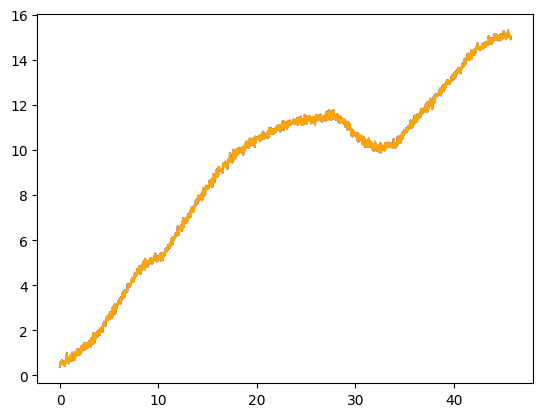

In [23]:
plt.plot(one_batch_hybrid['time'], one_batch_hybrid['biomass'], color='blue')
plt.plot(one_batch_plot['time'], one_batch_plot['biomass'], color='orange')